<a href="https://colab.research.google.com/github/OZebra/CaptainMarvel/blob/master/DataScience_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto 2 de DataScience 

---

##Objetivos


1.   Escolher uma coluna para realizar predição por regressão ou classificação.
2.   Separar os dados em treinamento, validação e teste.
3.   Selecionar 4 algorítmos de acordo com a tarefa escolhida no passo 1
4.   Adicionar MLFlow no treinamento dos modelos para rastreamento.
5.   Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação.
     1. Selecionar poucos Hiper-parâmetros por algorítmo (max: 3).
     2. Selecionar o conjunto algorítmo + hiperparâmetros com o melhor resultado
     3. Executar o melhor modelo para cada algorítmo e selecionar o melhor.

6. Realizar o diagnóstico geral do modelo escolhido e melhorá-lo a partir do diagnóstico


##Parte 1

---

O dataset escolhido, será [este](https://www.kaggle.com/adityakadiwal/water-potability/version/3).

O dataset trata da predição de derrame baseado em exames e fatores pessoais da vida dos paciêntes.

Vamos começar importando as bibliotecas necessárias



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

In [2]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install optuna

import mlflow
import optuna

     |████████████████████████████████| 14.4 MB 61 kB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 170 kB 52.8 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 56.9 MB/s 
     |████████████████████████████████| 636 kB 55.6 MB/s 
     |████████████████████████████████| 146 kB 57.7 MB/s 
     |████████████████████████████████| 75 kB 3.3 MB/s 
     |████████████████████████████████| 52 kB 836 kB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 746 kB 5.0 MB/s 
     |████████████████████████████████| 302 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 141 kB 10.9 MB/s 
     |████████████████████████████████| 111 kB 9.2 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256

Configurando MLFlow

In [3]:

with mlflow.start_run():
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

get_ipython().system_raw("mlflow ui --port 5000 &")

from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = "1wbnBFUrJ5h6yC62xQKhBAg2d6j_7VXzU961dGaomVXmeKr1y"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://863b1642094c.ngrok.io


# 🧭 Exploração

Agora, podemos carregar o dataset e realizar uma análise exploratória dos nossos dados.

In [5]:
df_stroke = pd.read_csv("/content/water_potability.csv")

In [6]:
df_stroke.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [7]:
df_stroke.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [8]:
df_stroke.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Como podemos perceber, algumas propriedades como 'hypertension', e 'stroke' provavelmente variam bináriamente indicando presença ou não da doença/condição

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


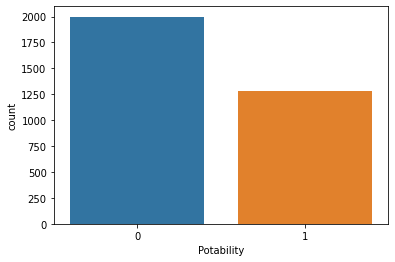

In [9]:
df_stroke.info()
df_stroke.isnull().sum()
sns.countplot(x='Potability', data=df_stroke);

Observando a descrição do dataset no kaggle, podemos perceber que existem três colunas que possuem algum valor inválido, sendo elas: "Trihalomethanes", "Sulfate" e "pH". Vamos filtrar esses valores inválidos.

In [10]:
df_stroke = df_stroke.drop(df_stroke[df_stroke.Trihalomethanes.isna()].index)
df_stroke = df_stroke.drop(df_stroke[df_stroke.ph.isna()].index)
df_stroke = df_stroke.drop(df_stroke[df_stroke.Sulfate.isna()].index)

E em seguida, podemos verificar novamente o dataframe.

In [11]:
df_stroke.count()

ph                 2011
Hardness           2011
Solids             2011
Chloramines        2011
Sulfate            2011
Conductivity       2011
Organic_carbon     2011
Trihalomethanes    2011
Turbidity          2011
Potability         2011
dtype: int64

A partir daqui, dividiremos o dataframe em treino, teste e validação e começaremos a iterar em cima dos algorítmos com o auxílio do MLFlow.

In [12]:
from sklearn.model_selection import train_test_split

x = df_stroke.drop(columns = ['Potability']).copy()
y = df_stroke['Potability']


x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_rem,y_rem, test_size=0.5)

Também estaremos utilizando o optuna para realizar a otimização de hiper-parâmetros

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def KNNOptimization(trial):
    # hyperparameter setting
    neighbors = trial.suggest_int('n_neighbours', 20, 200)
    
    # model training and evaluation
    with mlflow.start_run():
      knn = KNeighborsClassifier(n_neighbors=neighbors)
      knn.fit(x_train, y_train)
      y_pred = knn.predict(x_test)

      cr = classification_report(y_test, y_pred, output_dict=True)

      precision = cr['1']['precision']
      f1score = cr['1']['precision']
      error = sklearn.metrics.mean_squared_error(y_test, y_pred)

      mlflow.log_param("n_neighbors", neighbors);
      mlflow.log_metric("precision", precision);
      mlflow.log_metric("f1-score", f1score);
      mlflow.log_metric("error", error);
      return error

study = optuna.create_study(direction='minimize')
study.optimize(KNNOptimization, n_trials=20)

[I 2021-08-12 04:38:50,808] A new study created in memory with name: no-name-30ffb734-6f8a-402b-8b17-56563d015562
[I 2021-08-12 04:38:50,847] Trial 0 finished with value: 0.3613861386138614 and parameters: {'n_neighbours': 92}. Best is trial 0 with value: 0.3613861386138614.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2021-08-12 04:38:50,883] Trial 1 finished with value: 0.3613861386138614 and parameters: {'n_neighbours': 90}. Best is trial 0 with value: 0.3613861386138614.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2021-08-12 04:38:50,917] Trial 2 finished w